# ACSE-4.4
## Entropy - Training a classifier on Tiny ImageNet

In [2]:
!pip install pycm livelossplot
!pip install opencv-python
%pylab inline


     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 552kB 6.3MB/s 
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Normalize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
!ls './'
path = './'

sample_data


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import transforms, datasets, models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score
from PIL import Image
from os import listdir
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json
import pandas as pd

from livelossplot import PlotLosses
from pycm import *

In [0]:
'''
HYPER-PARAMETERS
'''
seed = 42               # Seed for random numbers
lr = 1e-2               # Optimizer step scaling in gradient descent
mom = 0.9               # momentum of optimizer (SGD)
batch_size = 32         # training batch size
test_batch_size = 64    # test batch size (higher is faster but be careful of memory bounds)
n_epochs = 7            # number of training epochs

# Image parameters
img_mean, img_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225);    # Image means and standard deviations for normalization
img_size = 224      # Dimension (pixels) to resize the input image to
num_classes = 200   # Classification dimensions
model_save_name = 'W_ResNet50_224_min_aug_SGD.pth'     # Save name for model state dictionary and predictions .csv file

In [6]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

set_seed(seed)
# Set to cuda ordinal 0 but can be set to whatever ordinal is freest
device =  torch.device('cuda' if (torch.cuda.device_count() > 0 and torch.cuda.is_available()) else 'cpu')
print(device)

cuda


In [0]:
# Automatically access imagenet 
imagenet = datasets.ImageFolder(root=F'{path}/train/')

# Convert label codes into numbers
with open(F'{path}/mapping.json') as f:
    mapping = json.load(f)

labels = [mapping[filename[0].split('/')[-3]] for filename in imagenet.samples]
print(labels[::500])
print(len(labels))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
100000


In [0]:
''' Initialize a shuffler object (iterable) seeded with our seed hyperparameter for consistency
and set test_size to 0.1 that splits samples and targets into training
and validation sets in a way that conserves their class proportions. '''


# Define stratified shuffling item to preserve class proportions
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed).split(imagenet.samples, labels)
# Collect indices arrays that represent which samples are assigned as training or validation.
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]
# Reallocate to data and targets for training and validation
X_train, y_train = np.array(imagenet.samples)[indices[0]].tolist(), np.array(labels)[indices[0]].tolist()
X_val, y_val = np.array(imagenet.samples)[indices[1]].tolist(), np.array(labels)[indices[1]].tolist()

In [0]:
# Define our own class through which we can apply our normalization and re-jigging
# of the data format.
class TinyImageNet(Dataset):
    def __init__(self, data, targets, transform=None, resize=True, size = 224):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform
        self.resize = resize
        self.size = int(size)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Defines how a datum and its target is accessed
        sample, label = self.data[idx], self.targets[idx]
        sample = Image.open(sample[0])
        sample = np.asarray(sample, dtype=np.float32)/255.
        # Resize the image
        if self.resize:
            sample = cv2.resize(np.asarray(sample), (self.size, self.size), interpolation=cv2.INTER_CUBIC)
        # If in greyscale
        if sample.ndim == 2:
            tmp = np.zeros((img_size, img_size, 3), dtype=np.float32)
            for c in range(3):
                tmp[:,:,c] = sample
            sample = tmp
        # Convert back to Tensor before doing transforms
        sample = ToTensor()(sample)
        if self.transform:
            # Apply transformations on-the-fly
            sample = self.transform(sample)

        return sample, label

In [0]:
imagenet_transforms = Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    Normalize(img_mean, img_std)])

# Define basic test transforms to be used to make predictions
test_transforms = Normalize(img_mean, img_std)

imagenet_train = TinyImageNet(X_train, y_train, transform=imagenet_transforms, resize=True, size=img_size)
imagenet_val = TinyImageNet(X_val, y_val, transform=test_transforms, resize=True, size=img_size)
# Define our dataloaders for each set, seting num_workers to 4 to call 4 threads to do task of loading
# and transforming data.
train_loader = DataLoader(imagenet_train, batch_size=batch_size, 
                          shuffle=True, num_workers=4)    # Training set shuffled on every epoch
val_loader = DataLoader(imagenet_val, batch_size=test_batch_size, 
                          shuffle=False, num_workers=4)   # No need to shuffle as no learning will occur on these

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


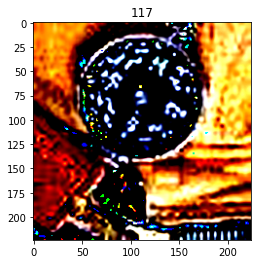

In [0]:
example_data, example_label = imagenet_train[seed]
plt.imshow(example_data.permute(1, 2, 0))   # C, H, W -> permute -> H, W, C
plt.title(example_label)
plt.show()

In [0]:
def train(model, optimizer, criterion, data_loader):
    '''
    Trains input model and calculates training loss and accuracy in return.
    '''
    print_checkpoint = 0                # Update progress info when it reaches this point
    jump = 10                           # How often to print progress (%)
    model.train() # set to training-mode to access the training behaviour of model
    train_loss, train_accuracy = 0., 0. # Initialize rolling sum of loss and accuracies
    cnt = 0                             # Used to calculate progress (running count of samples processed)
    for X, y in data_loader:            # Iterate over every batch (B) of X (B, C, H, W) and Y 
        X, y = X.to(device), y.to(device) # Send to device (cuda)
        optimizer.zero_grad()             # Reset gradients
        # ! Batch size set to -1 as this will make PyTorch work out what the remainder should be
        # ! LeNet5 base class overwrites __call__() to run forward when it's accessed like this
        a2 = model(X.view(-1, 3, img_size, img_size).float()) # Run forward model
        loss = criterion(a2, y)           # Calculate BCE Loss
        loss.backward()                   # Backpropagate error associated with batch
        train_loss += loss*X.size(0)      # Accumulate loss over batch
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]   # Make predictions based on highest softmax output
        # Accumulate accuracy over batch.                 ... Detach y_pred from computational graph
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()                  # Take a (stochastic) gradient descent step
        cnt += batch_size
        # Update user on progress
        progress = int(cnt/len(imagenet_train) * 100)
        if progress > print_checkpoint:
            print(cnt,"/",len(imagenet_train)," ==> ", progress, "% of epoch")
            print_checkpoint += jump
    
    # Return training loss and accuracies normalized by the dataset size
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    '''
    Calculate performance metrics without running any optimizations.
    '''
    model.eval()  # Set to evaluation mode to avoid learning procedures in model
    validation_loss, validation_accuracy, validation_f1 = 0., 0., 0.;
    for X, y in data_loader:                  # Iterate over every batch (B) of X (B, C, H, W) and Y 
        with torch.no_grad():                 # Deactivate the autograd routine
            X, y = X.to(device), y.to(device) # Send to device (cuda)
            a2 = model(X.view(-1, 3, img_size, img_size).float()) # Run forward model
            loss = criterion(a2, y)           # Calculate BCE Loss
            validation_loss += loss*X.size(0) # Accumulate loss over batch
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # Make predictions based on highest softmax output
            # Accumulate accuracy over batch.
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            validation_f1 += f1_score(y.cpu().numpy(), y_pred.cpu().numpy(), average='macro')*X.size(0)
    # Return training loss and accuracies normalized by the dataset size
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset), validation_f1/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    '''
    Calculate performance metrics without running any optimizations.
    '''
    model.eval()  # Set to evaluation mode to avoid learning procedures in model
    ys, y_preds = [], []  # Keep track of what predictions and labels
    for X, y in data_loader:                  # Iterate over every batch (B) of X (B, C, H, W) and Y 
        with torch.no_grad():                 # Deactivate the autograd routine
            X, y = X.to(device), y.to(device) # Send to device (cuda)
            a2 = model(X.view(-1, 3, img_size, img_size).float()) # Run forward model
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # Make predictions based on highest softmax output
            ys.append(y.cpu().numpy())                  # Get actual class and append to ground truth list
            y_preds.append(y_pred.cpu().numpy())        # Append to predictions list
    # Return predictions and ground truths list
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

def predict(model, data_loader):
    '''
    Calculate performance metrics without running any optimizations.
    '''
    model.eval()        # Set to evaluation mode to avoid learning procedures in model
    y_preds = []    # Keep track of what predictions and labels
    for X, y in data_loader:                  # Iterate over every batch (B) of X (B, C, H, W) and Y 
        with torch.no_grad():                 # Deactivate the autograd routine
            X = X.to(device)                  # Send to device (cuda)
            a2 = model(X.view(-1, 3, img_size, img_size).float()) # Run forward model
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # Make predictions based on highest softmax output
            y_preds.append(y_pred.cpu().numpy())        # Append to predictions list
    # Return predictions and ground truths list
    return np.concatenate(y_preds, 0)

In [0]:
# Load Wide RESNET50 with state dictionary pretrained on ImageNet
# < arXiv:1512.03385 >
'''
Deep Residual Learning framework to assist in extremely deep learning.
Allows stacked layers to learn a residual mapping by including 'short-cut'-connections
and summing the identity (input) with the weighted output of the layers being
skipped over to find the underlying mapping, which is easier to optimise for. The
gradients are subsequently easily backpropagated by SGD (He, et al., 2015).
'''
model = models.wide_resnet50_2(pretrained=True)
in_ftrs = model.fc.in_features   # Find how many features fed into last fc layer
model.fc.out_features = num_classes  # Redefine out-dimension attribute
model.fc = nn.Linear(in_features=in_ftrs, out_features=num_classes)  # Reshape last layer
model = model.to(device)         # Do computation of this model on designated device
     
# Gather the parameters to be optimized/updated in this run into a list and feed
# it into the optimizer
params_to_update = model.parameters()
print("Parameters to learn:")
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name, param.requires_grad)

#Loss Function
criterion = nn.CrossEntropyLoss()
# Define gradient descent method - Stochastic Gradient Descent, as suggested by He, et al., 2015
# Found to have markedly improved learning qualities over Adam (which garnered only 30% in previous trials)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=mom)

Parameters to learn:
	 conv1.weight True
	 bn1.weight True
	 bn1.bias True
	 layer1.0.conv1.weight True
	 layer1.0.bn1.weight True
	 layer1.0.bn1.bias True
	 layer1.0.conv2.weight True
	 layer1.0.bn2.weight True
	 layer1.0.bn2.bias True
	 layer1.0.conv3.weight True
	 layer1.0.bn3.weight True
	 layer1.0.bn3.bias True
	 layer1.0.downsample.0.weight True
	 layer1.0.downsample.1.weight True
	 layer1.0.downsample.1.bias True
	 layer1.1.conv1.weight True
	 layer1.1.bn1.weight True
	 layer1.1.bn1.bias True
	 layer1.1.conv2.weight True
	 layer1.1.bn2.weight True
	 layer1.1.bn2.bias True
	 layer1.1.conv3.weight True
	 layer1.1.bn3.weight True
	 layer1.1.bn3.bias True
	 layer1.2.conv1.weight True
	 layer1.2.bn1.weight True
	 layer1.2.bn1.bias True
	 layer1.2.conv2.weight True
	 layer1.2.bn2.weight True
	 layer1.2.bn2.bias True
	 layer1.2.conv3.weight True
	 layer1.2.bn3.weight True
	 layer1.2.bn3.bias True
	 layer2.0.conv1.weight True
	 layer2.0.bn1.weight True
	 layer2.0.bn1.bias True
	 layer2.

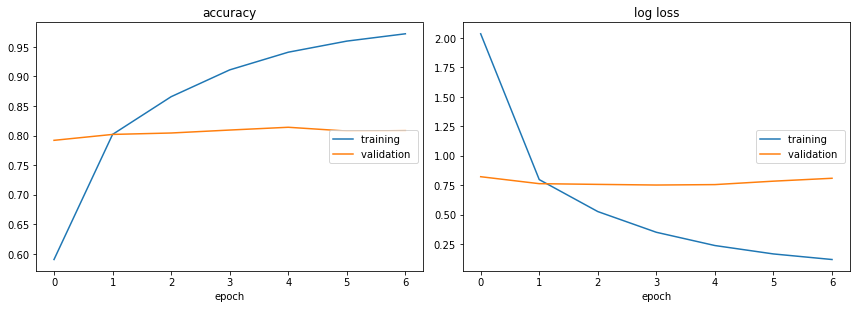

accuracy
	training         	 (min:    0.508, max:    0.972, cur:    0.972)
	validation       	 (min:    0.722, max:    0.814, cur:    0.808)
log loss
	training         	 (min:    0.117, max:    2.274, cur:    0.117)
	validation       	 (min:    0.751, max:    1.117, cur:    0.808)
Epoch = 7
Training
928 / 90000  ==>  1 % of epoch
9920 / 90000  ==>  11 % of epoch


KeyboardInterrupt: 

In [0]:
goat_accuracy = 0.    # keep track of best accuracy
liveloss = PlotLosses()
for epoch in range(n_epochs):
    print("Epoch =", epoch)
    logs = {}
    # Send model in to be trained over the epoch
    print("Training")
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    print("Validating")
    # Validate with the test set along the way to track how the model has generalized
    validation_loss, validation_accuracy, f1 = validate(model, criterion, val_loader)

    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    # Save only the model that performs best on validation (test) set, as measured by loss
    if validation_accuracy.item() > goat_accuracy:
        goat_loss = validation_loss.item()
        goat_accuracy = validation_accuracy.item()
        torch.save(model.state_dict(), F"./models/{model_save_name}")

    print("Plotting")
    liveloss.update(logs)
    liveloss.draw()

# Validate model at the end to access performance metrics
test_loss, test_accuracy, test_f1 = validate(model, criterion, val_loader)    
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())


In [0]:
print("Retrieving model")
model = models.wide_resnet50_2(pretrained=False)
# Determine the inputs to reshaped layer
in_ftrs = model.fc.in_features
# Re-define out_features attribute (not necessary but makes explicit)
model.fc.out_features = num_classes
# Overwrite last layer to match our problem dimensions
model.fc = nn.Linear(in_features=in_ftrs, out_features=num_classes)
# Load in according model state dict
model.load_state_dict(torch.load(F'{path}/models/{model_save_name}'))
# Send to device
model = model.to(device)

# Check that the model has loaded correctly to check such that performance metrics match those above
print("Validating")
loss, acc, f1 = validate(model, criterion, val_loader)
print("="*80)
print("Loss = %.3f \t || \t Accuracy = %.3f \t || \t F1 = %.3f" % (loss, acc, f1))
print("="*80)

# Define basic test transforms to be used to make predictions
test_transforms = Compose([
    Resize(224),
    ToTensor(),
    Normalize(img_mean, img_std)])

# Just use ImageFolder dataset to automatically load test data and apply it with new
# transforms to account for it being originally PIL (from JPEG)
imagenet_test = datasets.ImageFolder(root=path + 'test/', transform=test_transforms)
titles = [filename[0].split('/')[-1].lower() for filename in imagenet_test.samples]
# Make sure shuffle is set to FALSE to match corresponding labels
test_loader = DataLoader(imagenet_test, batch_size=batch_size, shuffle=False, num_workers=0)

# Make predictions 
y_pred = predict(model, test_loader)
# get filename (without extension .pt or .pth)
csv_name = model_save_name.split('.')[0]
# Save in submission folder
pd.DataFrame({'Filename': titles, 'Label': y_pred}).to_csv(F'{path}/submit/Entropy_{csv_name}.csv', index=False)

Retrieving model
Validating
Loss = 0.776 	 || 	 Accuracy = 0.810 	 || 	 F1 = 0.697
